In [24]:
!pip install pandas matplotlib numpy
!pip install scikit-survival

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

set_config(display="text")  # displays text representation of estimators

In [26]:
data = pd.read_csv("data/Recurrence free survival in breast cancer patients.csv")  # Load your CSV file
X = data.drop(columns=["id", "time", "status"])

from sksurv.util import Surv
y = Surv.from_arrays(event=data["status"] == 1, time=data["time"])

# Example of handling 'gender' with OrdinalEncoder, adjust for other columns as needed
from sklearn.preprocessing import OrdinalEncoder

Xt = X  # Use X or continue with OneHotEncoder if you need further encoding

In [27]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

print(X_train.shape)

# Fit the Random Survival Forest on the reduced dataset

# New code added (Hyperparameter Tuning)
from sklearn.model_selection import GridSearchCV
from sksurv.metrics import concordance_index_censored
from sklearn.metrics import make_scorer  

def cindex_scorer(estimator, X, y):
    surv_funcs = estimator.predict_survival_function(X)
    time = np.array([y_val[1] for y_val in y])
    event = np.array([y_val[0] for y_val in y])
    
    # Get the predicted median survival time
    preds = np.array([sf.x[sf.y <= 0.5][0] if np.any(sf.y <= 0.5) else sf.x[-1] for sf in surv_funcs])
    
    return concordance_index_censored(event, time, preds)[0]


param_grid = {
     'n_estimators': [100, 500, 1000],  # Number of trees
     'min_samples_split': [2, 5, 10],   # Min samples to split a node
     'min_samples_leaf': [1, 2, 4],     # Min samples at a leaf node
     'max_depth': [None, 10, 20],       # Max depth of the tree     'max_features': ['sqrt', 'log2']   # Max features for best split
 }


(514, 8)


In [28]:
rsf = RandomSurvivalForest(random_state=random_state)

grid_search = GridSearchCV(
     estimator=rsf,
     param_grid=param_grid,
     cv=5,  # Cross-validation folds
     n_jobs=2,  # Use all available cores
     scoring=cindex_scorer,  # Use concordance index as the scoring metric
     verbose=2
 )

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
best_rsf = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   2.0s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.9s
[CV] END max_depth=

/opt/miniconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   3.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_esti

In [29]:
best_rsf.score(X_test, y_test)

0.6721698113207547

In [30]:
X_test_sorted = X_test.sort_values(by=["nodes", "prog"])
X_test_sel = X_test_sorted.iloc[:10]

X_test_sel

,treat,age,men,size,grade,nodes,prog,oest
363,0,51,1,21,3,1,0,0
121,0,45,1,29,2,1,0,0
319,0,56,2,40,3,1,0,3
574,0,34,1,40,3,1,0,37
560,0,44,1,15,2,1,0,0
644,0,45,1,25,3,1,0,4
434,0,50,1,18,3,1,1,4
415,1,39,1,20,3,1,2,2
270,0,46,1,12,2,1,6,49
593,0,65,2,35,2,1,7,74


In [31]:
pd.Series(best_rsf.predict(X_test_sel))

0    52.244720
1    51.238336
2    90.512158
3    83.880036
4    38.145948
5    68.211303
6    72.446483
7    54.690550
8    29.640333
9    55.262716
dtype: float64

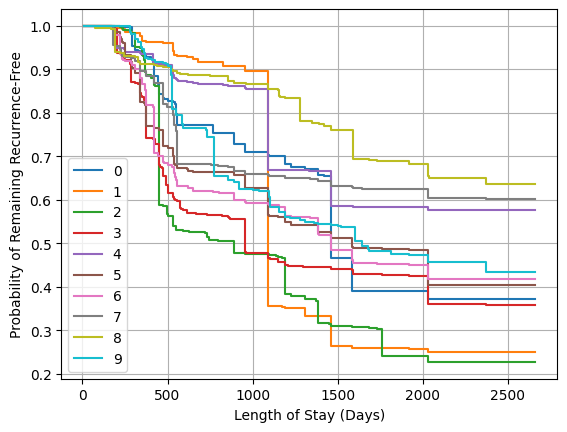

In [32]:
surv = best_rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(best_rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Probability of Remaining Recurrence-Free")
plt.xlabel("Length of Stay (Days)")
plt.legend()
plt.grid(True)

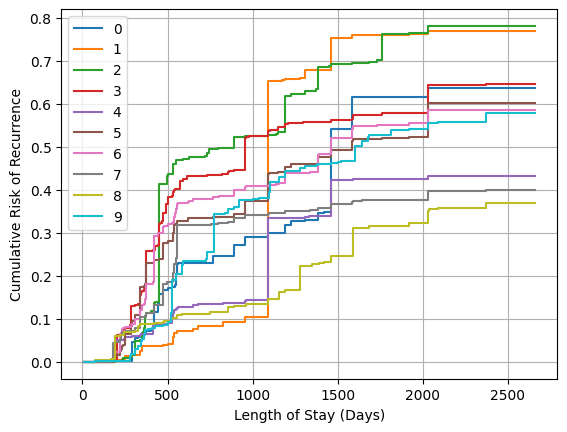

In [33]:
surv = best_rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(best_rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative Risk of Recurrence")
plt.xlabel("Length of Stay (Days)")
plt.legend()
plt.grid(True)

In [34]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_rsf, X_test, y_test, n_repeats=5, random_state=random_state)

In [35]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
nodes,0.058281,0.026778
age,0.018553,0.008868
grade,0.018134,0.012619
treat,0.013391,0.006274
prog,0.009617,0.021848
oest,0.007154,0.014508
size,-0.003249,0.009764
men,-0.006027,0.004405
